## ECG Classification Using Convolutional Neural Networks

Author: Calvin Chan 

### Introduction
In our last notebook, we will use the concept of convolution to model our ECG timeseries data. Traditionally, image analysis uses a 2D convolution to extract features from images, however since we are working with signals this would not work. Instead of 2D convolutions, we can convolve over our signals using a 1D framework. 

### Table of Contents

Here, we import all the necessary packages used in this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import load_functions as f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm.notebook import trange, tnrange, tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

### Data Import

Below we load our full data set.

In [3]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [4]:
# Let's look at the data shape 
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

We also want to look at Lead II only. 

In [5]:
# Slicing only for Lead II 
X = full_data[0][:,:,1]
y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

### Data Preprocessing 

In [6]:
# Transform target column into binary classes
y = y.apply(lambda x: f.binary(x))

In [7]:
# Sanity check
y.value_counts()

diagnostic_superclass
ABNO    8645
NORM    7032
Name: count, dtype: int64

In [8]:
# Instantiate LabelEncoder 
label = LabelEncoder()

# Fit binary classes
label.fit(y)

# Transform classes
y = label.transform(y)

In [9]:
# Checking how our label is encoded
label.transform(['ABNO', 'NORM'])

array([0, 1])

As we can see, signals that are labeled `ABNO` are mapped to `0` and `NORM` are mapped `1`. 

#### Signal denoising using ecg_cleaning.py

In this following section, we denoise our ECG signals using Fourier Tranforms. We have to specify the frequencies in which we want to take out for baseline wandering and powerline interference. 

In [10]:
X.shape

(15677, 1000)

In [11]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

In [12]:
signal_pli.shape

(15677, 1000)

#### Train Test Split

After preprocessing our signals, we can split our data set to training and testing. We will use `20%` of our data as testing and the rest as training. Since we have a data imbalance, we will include `stratify` as well.  

In [13]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y)

# Checking the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12541, 1000), (3136, 1000), (12541,), (3136,))

#### Scaling 

Next, we want to scale our data. Since we are using using a neural network, as we calculate the gradient during backpropagation, distances can affect how well this is performed. We will use `StandardScaler` for our case.

In [14]:
# Instantiate standard scaler
ss = StandardScaler()

# Fit and transform training set
X_train = ss.fit_transform(X_train)

# Transform testing set
X_test = ss.transform(X_test)

#### Transforming arrays into Torch Tensors

In [15]:
# Transforming independent variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Transforming dependent variables
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([12541, 1000]) torch.Size([3136, 1000]) torch.Size([12541]) torch.Size([3136])


#### Data Loaders

In [62]:
####### Setting batch size #######
batch_size = 128

# Shuffle training set
training_loader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=batch_size, shuffle=True)

# Don't shuffle validation set
testing_loader = DataLoader(TensorDataset(X_test.unsqueeze(1), y_test.unsqueeze(1)), batch_size=batch_size, shuffle=False)

In [297]:
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)

training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model Setup and Implementation

In [302]:
64*250

16000

In [317]:
class SimpleCNN(nn.Module):
    """Starting off with a simple cnn."""
    
    def __init__(self, lr=0.001):
        super(SimpleCNN, self).__init__()
        
        ##### CONVOLUTION LAYERS #####
        self.conv_layer = nn.Sequential(
            
            # Convolution block 1
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=11, padding=5),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            # nn.Dropout1d(0.2, inplace=True),
            
            # Convolution block 2
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=11, padding=5),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            # nn.Dropout1d(0.2, inplace=True),
            
            # Convolution block 3
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, padding=5),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=None),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            # nn.Dropout1d(0.2, inplace=True),
        )
        
        ##### FULLY-CONNECTED LAYERS #####
        self.fc_layer = nn.Sequential(
            # nn.Linear(in_features=64*250, out_features=400),
            nn.Linear(in_features=64*125, out_features=400),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=400, out_features=16),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=16, out_features=1),
        )
        
        ##### OUTPUT LAYER ##### 
        self.sigmoid = nn.Sigmoid()

        ##### LOSS FUNCTION #####
        self.binary_entropy_loss = nn.BCELoss()
        
        ##### OPTIMIZER #####
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, x): 
        """Perform forward pass."""

        # Pass through convolution layers
        x = self.conv_layer(x)
        
        # Flatten the output after convolution
        x = x.view(x.size(0), -1)
        
        # Pass through fully-connected layer
        x = self.fc_layer(x)
        
        x = self.sigmoid(x)
        
        return x

    def predict(self, x):
        """Make prediction."""

        predictions = self.forward(x)

        # Hard class prediction: output from sigmoid with the higher percentage
        hard_class_prediction = torch.argmax(predictions, dim=1)

        return hard_class_prediction


### Sample training on one signal

In [239]:
# Sample training 

sample = X_train[0]
sample_label = y_train[0]

print(sample.shape, sample_label.shape)

torch.Size([1000]) torch.Size([])


> **Note**: We have to add two dimensions to our data. Since we are dealing with 1 dimensional signals, the model takes an input tensor with the following format: `[batch_size, channels, signal_length]`.

We are using a batch size of 1 and since we are only using 1 Lead in our ECG signals, our channels is also 1.

In [240]:
# Using unsqueeze to add dimensions to our input signal
sample.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1000])

In [241]:
# Initializing the model

cnn_model = SimpleCNN()
cnn_model

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout1d(p=0.2, inplace=True)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout1d(p=0.2, inplace=True)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=8000, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
  (binary_entropy_loss): BCELoss()
)

In [242]:
# Clear any gradients from previous run (in this case this is our first and only run)
cnn_model.optimizer.zero_grad()

In [245]:
# Pass through 1 training signal to model after reshaping size
outputs = cnn_model(sample.unsqueeze(0).unsqueeze(0))

In [247]:
# Output after one pass
outputs

tensor([[0.4835]], grad_fn=<SigmoidBackward0>)

In [224]:
# Compute the binary entropy loss after one training and label
# Note, we need to transform the label to a tensor of the right size as well
loss = cnn_model.binary_entropy_loss(outputs, torch.tensor([[sample_label]]))

In [225]:
# Loss
loss

tensor(0.7268, grad_fn=<BinaryCrossEntropyBackward0>)

In [226]:
# Backpropagation - computes the gradients
loss.backward()

In [227]:
# Update weights
cnn_model.optimizer.step()

Let's create a function to evaluate the accuracy of our model given the model itself and the data set. 

In [309]:
def get_accuracy(model, dataloader):
    
    model.eval()
    
    correct_label = 0
    total_cases = 0
    
    # Pass through the data
    with torch.no_grad():
        for batch in dataloader:
            signal, label = batch

            # Get the prediction and compare to label
            prediction = model.predict(signal)

            # Get the number of samples in a batch
            total_cases += label.size(0)

            # Count the number of correctly predicted labels
            correct_label += (prediction == label).sum().item()
        
    return (correct_label / total_cases) * 100

In [312]:
get_accuracy(cnn_model, testing_loader)

55.13392857142857

### Training Model

In [322]:
# Instantiate model
CNN_model = SimpleCNN(lr=0.1)

In [323]:
# Loop over data 
for epoch in range(5):
    
    # Activate training model
    CNN_model.train()
    
    loss_sum = 0
    # accuracy_sum = 0
    accuracy_sum = []
    total_predictions = 0
    
    print(f"Training epoch: {epoch+1}")
    
    # Loop through batch in dataloader like in the function above
    for batch in training_loader:
        
        # Data from first batch (32 signals)
        inputs, labels = batch

        # Forward pass
        outputs = CNN_model(inputs)
        
        # Calculate loss
        # loss = CNN_model.binary_entropy_loss(outputs.squeeze(), labels)
        loss = CNN_model.binary_entropy_loss(outputs.squeeze(1), labels)
        
        # Clear gradients first from previous run
        CNN_model.optimizer.zero_grad()
        
        # Backpropagation - compute the gradients
        loss.backward()
        
        # Update model parameters based on computed gradients
        CNN_model.optimizer.step()
        
        # Save loss in this batch
        loss_sum += loss.item()
        
        # After updating the model, we want to compute the accuracy
        with torch.no_grad():
            predicted = CNN_model.predict(inputs)
            # accuracy_sum += (labels == predicted).sum().item() / len(labels)
            accuracy_sum.append((labels == predicted).sum().item() / len(labels))
            # total_predictions += labels.size(0)
            
    # After the batch, we want to calculate the average metrics
    loss_avg = loss_sum / len(training_loader)
    # accuracy_avg = accuracy_sum / total_predictions
    # print(accuracy_sum)
    accuracy_avg = np.average(accuracy_sum)
    
    # Calculate test accuracy after 1 epoch
    test_accuracy = get_accuracy(CNN_model, testing_loader)
    
    # Print results
    print(f"Average loss: {np.round(loss_avg, 4)} | "\
          f"Average training accuracy: {np.round(accuracy_avg*100, 4)} | "\
          f"Average testing accuracy: {np.round(test_accuracy, 4)}")
    
print("...Training finished")

Training epoch: 1
Average loss: 0.6863 | Average training accuracy: 55.1465 | Average testing accuracy: 55.1339
Training epoch: 2
Average loss: 0.6281 | Average training accuracy: 55.1449 | Average testing accuracy: 55.1339
Training epoch: 3
Average loss: 0.5308 | Average training accuracy: 55.148 | Average testing accuracy: 55.1339
Training epoch: 4
Average loss: 0.4514 | Average training accuracy: 55.1492 | Average testing accuracy: 55.1339
Training epoch: 5
Average loss: 0.4081 | Average training accuracy: 55.1465 | Average testing accuracy: 55.1339
...Training finished


### Accuracy Scores

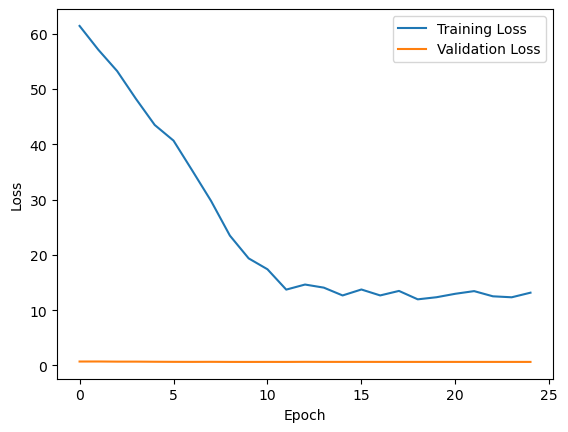

In [79]:
plt.figure()
plt.plot(total_train_loss, label="Training Loss")
plt.plot(total_test_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [126]:
from sklearn.metrics import accuracy_score

# Make predictions
binary_classification = CNN_model.predict(X_test.unsqueeze(1))

# Calculate the score on the test set
accuracy = accuracy_score(y_test, binary_classification)
print(f"Accuracy score on test set: {round(accuracy * 100, 2)}%")

Accuracy score on test set: 55.13%
